# 27. DCGAN

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

import torch.nn.init
from torch.autograd import Variable

import torchvision
import torchvision.datasets as dsets
import torchvision.transforms as transforms

import numpy as np
import os

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

## 27.1 Prepare MNIST Data

In [3]:
mnist_train = dsets.MNIST(root='data/',
                          train=True,
                          transform=transforms.ToTensor(),
                          download=True)

In [4]:
batch_size = 100

train_loader  = torch.utils.data.DataLoader(dataset=mnist_train,
                                           batch_size=batch_size,
                                           shuffle=False)

In [5]:
def imshow(img, title):
    npimg = img.numpy()
    fig = plt.figure(figsize = (5, 15))
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.title(title)
    plt.show()

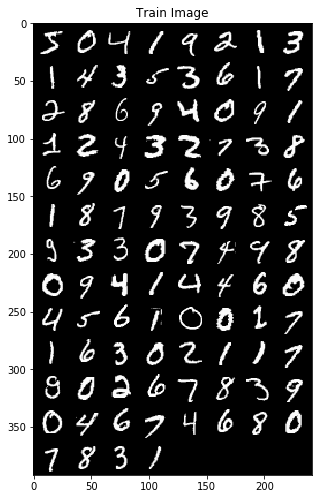

In [6]:
images, labels = iter(train_loader).next()
imshow(torchvision.utils.make_grid(images, normalize=True), "Train Image")

## 27.2 Define Model

In [7]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.discriminator = nn.Sequential(
            nn.Conv2d(1, 100, 4, stride=2, padding=1),
            nn.BatchNorm2d(100),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(100, 200, 4, stride=2, padding=1),
            nn.BatchNorm2d(200),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(200, 100, 4, stride=1, padding=0),
            nn.BatchNorm2d(100),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(100, 1, 4, stride=1, padding=0),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        out = self.discriminator(x)
        out = out.view(-1, 1)
        return out

In [8]:
D = Discriminator().cuda()

In [9]:
D(Variable(images).cuda()).shape

torch.Size([100, 1])

In [10]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.generator = nn.Sequential(
            nn.ConvTranspose2d(100, 200, 4, stride=1, padding=0),
            nn.BatchNorm2d(200),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(200, 400, 4, stride=1, padding=0),
            nn.BatchNorm2d(400),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(400, 200, 4, stride=2, padding=1),
            nn.BatchNorm2d(200),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(200, 1, 4, stride=2, padding=1),
            nn.Tanh()
        )
        
    def forward(self, x):
        x = x.view(-1, 100, 1, 1)
        out = self.generator(x)
        return out

In [11]:
G = Generator().cuda()

In [12]:
z = Variable(torch.randn((batch_size, 100))).cuda()
G(z).shape

torch.Size([100, 1, 28, 28])

## 27.3 Train Model

In [13]:
def gan_loss(x, target_is_real):
    
    loss = nn.BCELoss()
    
    if target_is_real : 
        target_tensor = torch.ones(batch_size, 1)
    else :
        target_tensor = torch.zeros(batch_size, 1)
        
    return loss(x, Variable(target_tensor).cuda())

In [14]:
G_optimizer = optim.Adam(G.parameters(), lr=0.0001)
D_optimizer = optim.Adam(D.parameters(), lr=0.0001)

In [15]:
num_epochs = 50

In [16]:
for epoch in range(num_epochs):
        
    total_batch = len(mnist_train) // batch_size
    
    for i, (images, labels) in enumerate(train_loader):
        
        images = Variable(images).cuda()
            
        prob_real = D(images)
        D_loss_real = gan_loss(prob_real, True)

        z = Variable(torch.randn((batch_size, 100))).cuda()
        fake_images = G(z)
        
        prob_fake = D(fake_images)
        D_loss_fake = gan_loss(prob_fake, False)
        
        D_loss = D_loss_real + D_loss_fake
        
        D.zero_grad()
        D_loss.backward()
        D_optimizer.step()
        
        z = Variable(torch.randn((batch_size, 100))).cuda()
        fake_images = G(z)
        
        prob_fake = D(fake_images)
        G_loss = gan_loss(prob_fake, True)
        
        G.zero_grad()
        G_loss.backward()
        G_optimizer.step()
        
        if (i+1) % 100 == 0:
            print('Epoch [%d/%d], lter [%d/%d], D_Loss: %.4f, G_Loss: %.4f'
                 %(epoch+1, num_epochs, i+1, total_batch, D_loss.data[0], G_loss.data[0]))

Epoch [1/50], lter [100/600], D_Loss: 0.4905, G_Loss: 1.4837
Epoch [1/50], lter [200/600], D_Loss: 0.2523, G_Loss: 2.2397
Epoch [1/50], lter [300/600], D_Loss: 0.1060, G_Loss: 3.0534
Epoch [1/50], lter [400/600], D_Loss: 0.1528, G_Loss: 2.9449
Epoch [1/50], lter [500/600], D_Loss: 0.0785, G_Loss: 3.9734
Epoch [1/50], lter [600/600], D_Loss: 0.0449, G_Loss: 3.6863
Epoch [2/50], lter [100/600], D_Loss: 0.0281, G_Loss: 3.8640
Epoch [2/50], lter [200/600], D_Loss: 0.0634, G_Loss: 3.8631
Epoch [2/50], lter [300/600], D_Loss: 0.0272, G_Loss: 5.1591
Epoch [2/50], lter [400/600], D_Loss: 0.0284, G_Loss: 4.6075
Epoch [2/50], lter [500/600], D_Loss: 0.0189, G_Loss: 5.9003
Epoch [2/50], lter [600/600], D_Loss: 0.2947, G_Loss: 7.7494
Epoch [3/50], lter [100/600], D_Loss: 0.0611, G_Loss: 4.6471
Epoch [3/50], lter [200/600], D_Loss: 0.0527, G_Loss: 4.7530
Epoch [3/50], lter [300/600], D_Loss: 0.0335, G_Loss: 6.3200
Epoch [3/50], lter [400/600], D_Loss: 0.0589, G_Loss: 4.7720
Epoch [3/50], lter [500/

Epoch [23/50], lter [300/600], D_Loss: 0.8509, G_Loss: 1.2001
Epoch [23/50], lter [400/600], D_Loss: 0.8365, G_Loss: 1.9442
Epoch [23/50], lter [500/600], D_Loss: 0.6208, G_Loss: 2.2700
Epoch [23/50], lter [600/600], D_Loss: 0.2916, G_Loss: 3.5394
Epoch [24/50], lter [100/600], D_Loss: 0.9570, G_Loss: 1.2774
Epoch [24/50], lter [200/600], D_Loss: 0.7407, G_Loss: 2.3884
Epoch [24/50], lter [300/600], D_Loss: 1.3417, G_Loss: 0.7878
Epoch [24/50], lter [400/600], D_Loss: 1.1598, G_Loss: 1.4575
Epoch [24/50], lter [500/600], D_Loss: 0.9563, G_Loss: 1.2341
Epoch [24/50], lter [600/600], D_Loss: 0.3549, G_Loss: 2.2786
Epoch [25/50], lter [100/600], D_Loss: 0.7518, G_Loss: 1.3322
Epoch [25/50], lter [200/600], D_Loss: 0.6205, G_Loss: 2.2408
Epoch [25/50], lter [300/600], D_Loss: 0.8216, G_Loss: 2.0592
Epoch [25/50], lter [400/600], D_Loss: 0.7295, G_Loss: 1.6490
Epoch [25/50], lter [500/600], D_Loss: 0.5976, G_Loss: 1.8132
Epoch [25/50], lter [600/600], D_Loss: 0.4094, G_Loss: 2.6894
Epoch [2

Epoch [45/50], lter [400/600], D_Loss: 0.6941, G_Loss: 2.3849
Epoch [45/50], lter [500/600], D_Loss: 0.7040, G_Loss: 2.3589
Epoch [45/50], lter [600/600], D_Loss: 0.7099, G_Loss: 1.0265
Epoch [46/50], lter [100/600], D_Loss: 0.9667, G_Loss: 0.9301
Epoch [46/50], lter [200/600], D_Loss: 0.7808, G_Loss: 1.5342
Epoch [46/50], lter [300/600], D_Loss: 0.7113, G_Loss: 1.9832
Epoch [46/50], lter [400/600], D_Loss: 0.9383, G_Loss: 1.8056
Epoch [46/50], lter [500/600], D_Loss: 0.5603, G_Loss: 2.0307
Epoch [46/50], lter [600/600], D_Loss: 0.4260, G_Loss: 1.6957
Epoch [47/50], lter [100/600], D_Loss: 0.9354, G_Loss: 1.2010
Epoch [47/50], lter [200/600], D_Loss: 0.6652, G_Loss: 2.0314
Epoch [47/50], lter [300/600], D_Loss: 0.7013, G_Loss: 1.8424
Epoch [47/50], lter [400/600], D_Loss: 0.7335, G_Loss: 2.5079
Epoch [47/50], lter [500/600], D_Loss: 0.5323, G_Loss: 2.0128
Epoch [47/50], lter [600/600], D_Loss: 0.3805, G_Loss: 2.1079
Epoch [48/50], lter [100/600], D_Loss: 0.8739, G_Loss: 1.1215
Epoch [4

## 27.4 Test Model

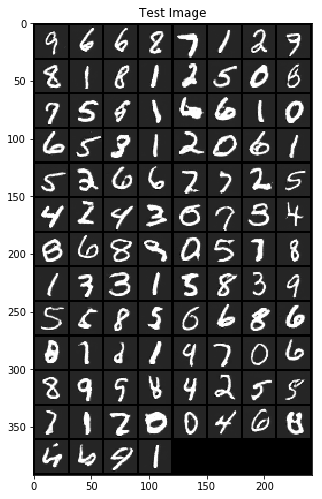

In [17]:
z = Variable(torch.randn((batch_size, 100))).cuda()
images = G(z)
imshow(torchvision.utils.make_grid(images.data.cpu(), normalize=True), "Test Image")